# Xopt class, TNK test function

This is the class method for running Xopt.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
from xopt import Xopt

import matplotlib.pyplot as plt
from botorch.utils.multi_objective.pareto import is_non_dominated
%matplotlib inline

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')


In [2]:
# To see log messages
import logging
from xopt import output_notebook
output_notebook('DEBUG')

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: null}

algorithm:
  name:  expected_hypervolume_improvement
  options: 
    ref: {'y1':1.4, 'y2':1.4}
    n_initial_samples: 10
    n_steps: 30
    batch_size: 1
  
evaluate:
  name: test_TNK
  function: xopt.tests.test_functions.TNK.evaluate_TNK
  
vocs:
  name: TNK_test
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {}
  constants: {a: dummy_constant}

"""
config = yaml.safe_load(YAML)

In [4]:
# Optional: Connect the function directly
#from xopt.evaluators.test_TNK import evaluate_TNK 
#config['simulation']['evaluate'] = evaluate_TNK 
if SMOKE_TEST:
    config['algorithm']['options']['n_steps'] = 3
    config['algorithm']['options']['generator_options']['num_restarts'] = 2
    config['algorithm']['options']['generator_options']['raw_samples'] = 2


X = Xopt(config)
X

Loading config from dict.
`name` keyword no longer allowed in vocs config, removing
Loading config from dict.
Loading config from dict.
Loading config from dict.
Loading config from dict.



            Xopt 
________________________________           
Version: 0.5.0+11.g9f5d950.dirty
Configured: True
Config as YAML:
xopt: {output_path: null}
algorithm:
  name: expected_hypervolume_improvement
  options:
    ref: {y1: -1.4, y2: -1.4}
    n_initial_samples: 10
    n_steps: 30
    batch_size: 1
    output_path: .
    sigma: null
    mc_samples: 1024
  type: batched
  function: null
evaluate:
  name: test_TNK
  function: xopt.tests.test_functions.TNK.evaluate_TNK
  executor: null
  options: {extra_option: abc}
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {}
  constants: {a: dummy_constant}

# Run MOBO

MOBO is designed to run in serial or parallel

In [5]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

executor = PoolExecutor()
# This will also work. 
#executor=None

In [6]:
%%time
results = X.run()

Starting at time 2021-10-18T10:45:17-05:00
Generating and submitting initial samples
generating samples
generated 1 samples in 3.723 seconds
samples
         x1        x2
0  0.441754  1.083049
collecting results
saving data to file
generating samples
generated 1 samples in 3.388 seconds
samples
    x1        x2
0  0.0  0.395852
collecting results
saving data to file
generating samples
generated 1 samples in 4.854 seconds
samples
        x1        x2
0  0.09163  1.153923
collecting results
saving data to file
generating samples
generated 1 samples in 4.008 seconds
samples
         x1        x2
0  0.073776  0.880839
collecting results
saving data to file
generating samples
generated 1 samples in 4.628 seconds
samples
         x1        x2
0  0.121386  1.060678
collecting results
saving data to file
generating samples
generated 1 samples in 4.25 seconds
samples
         x1   x2
0  1.061549  0.0
collecting results
saving data to file
generating samples
generated 1 samples in 3.787 seconds


# Plot

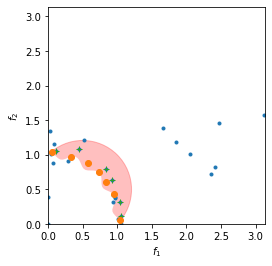

In [7]:
import torch
import numpy as np
fig, ax = plt.subplots()

# get results and get valid observations
train_y = results[config['vocs']['objectives']].to_numpy()
valid_y = torch.tensor(train_y[results['feas']])

# plot results
ax.plot(train_y[:, 0], train_y[:, 1], '.')
ax.set_ylabel('$f_2$')
ax.set_xlabel('$f_1$')

# highlight Pareto front, ONLY using valid observations (note botorch assumes maximization when determing dominant points)
non_dom = is_non_dominated(-valid_y)
ax.plot(valid_y[:,0],valid_y[:,1],'C2+')
ax.plot(valid_y[:,0][non_dom],valid_y[:,1][non_dom],'C1o')

# plot valid region
theta = np.linspace(0,np.pi/2)
r = np.sqrt(1 + 0.1*np.cos(16*theta))
x_1 = r*np.sin(theta)
x_2_lower = r*np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5)**2)**0.5 + 0.5

z = np.zeros_like(x_1)

#ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc='white')
circle = plt.Circle((0.5, 0.5), 0.5**0.5,
                    color='r', alpha=0.25, zorder=0,
                    label='Valid Region')
ax.add_patch(circle)
ax.set_xlim(0,np.pi)
ax.set_ylim(0,np.pi)
ax.set_aspect('equal')

plt.show()

In [8]:
results

,x1,x2,a,y1,y2,c1,c2,some_array,status,x1_t,x2_t,y1_t,y2_t,c1_t,c2_t,c1_f,c2_f,feas
0,1.846132,1.190409,dummy_constant,1.846132,1.190409,3.921886,2.288737,"[1, 2, 3]",done,0.587643,0.378919,1.318666,0.850292,-1.164372,0.765124,True,False,False
1,3.124707,1.579328,dummy_constant,3.124707,1.579328,11.222259,8.054035,"[1, 2, 3]",done,0.994626,0.502716,2.231933,1.128091,-3.331787,3.231205,True,False,False
2,2.474662,1.457884,dummy_constant,2.474662,1.457884,7.311018,4.816831,"[1, 2, 3]",done,0.787710,0.464059,1.767616,1.041346,-2.170575,1.846505,True,False,False
3,2.411224,0.820249,dummy_constant,2.411224,0.820249,5.435909,3.755335,"[1, 2, 3]",done,0.767517,0.261093,1.722303,0.585892,-1.613872,1.392455,True,False,False
4,2.359114,0.722843,dummy_constant,2.359114,0.722843,5.083448,3.505966,"[1, 2, 3]",done,0.750930,0.230088,1.685082,0.516317,-1.509230,1.285788,True,False,False
5,0.031999,1.349332,dummy_constant,0.031999,1.349332,0.728832,0.940390,"[1, 2, 3]",done,0.010186,0.429506,0.022857,0.963809,-0.216384,0.188375,True,False,False
6,0.832690,0.794055,dummy_constant,0.832690,0.794055,0.231025,0.197150,"[1, 2, 3]",done,0.265054,0.252756,0.594778,0.567182,-0.068589,-0.129543,True,True,True
7,1.668365,1.386585,dummy_constant,1.668365,1.386585,3.696158,2.151109,"[1, 2, 3]",done,0.531057,0.441364,1.191689,0.990418,-1.097356,0.706255,True,False,False
8,2.057784,1.009562,dummy_constant,2.057784,1.009562,4.200885,2.686345,"[1, 2, 3]",done,0.655014,0.321354,1.469846,0.721115,-1.247204,0.935199,True,False,False
9,0.517024,1.211661,dummy_constant,0.517024,1.211661,0.636875,0.506751,"[1, 2, 3]",done,0.164574,0.385684,0.369303,0.865472,-0.189082,0.002888,True,False,False


C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_6232/3387559987.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolor(*xx, m[idx].reshape(n,n))
C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_6232/3387559987.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolor(*xx, cdf.reshape(n,n))


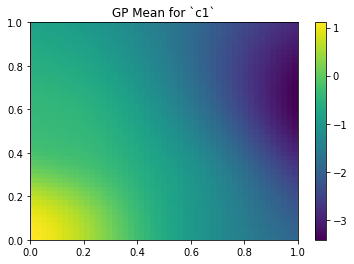

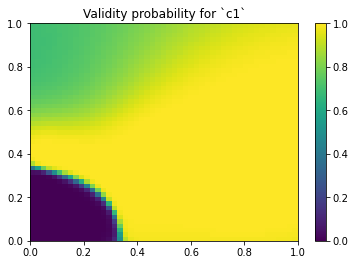

In [9]:
model = X.generator.model

n = 50
x = np.linspace(0,1,n)
xx = np.meshgrid(x, x)
pts = np.vstack([ele.ravel() for ele in xx]).T
pts = torch.tensor(pts)

with torch.no_grad():
    post = model(pts)
    m = post.mean
    var = post.variance

# plot model mean and valid probability for first constraint c1
idx = 2
cdf = 0.5*(1 + torch.erf((0 - m[idx])/(2*torch.sqrt(var[idx]))))
fig, ax = plt.subplots()
ax.set_title('GP Mean for `c1`')
c = ax.pcolor(*xx, m[idx].reshape(n,n))
fig.colorbar(c)

fig, ax = plt.subplots()
ax.set_title('Validity probability for `c1`')
c = ax.pcolor(*xx, cdf.reshape(n,n))
fig.colorbar(c)

C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_6232/3421164944.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolor(*xx, val.reshape(n,n))


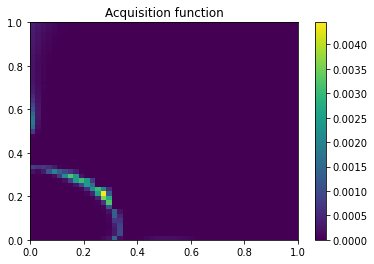

In [10]:
# plot acquisition function
acq = X.generator.acqisition_function(model, **X.generator.acqisition_function_options)

n = 50
x = np.linspace(0,1,n)
xx = np.meshgrid(x, x)
pts = np.vstack([ele.ravel() for ele in xx]).T
pts = torch.tensor(pts)

with torch.no_grad():
    val = acq(pts.unsqueeze(1))

fig, ax = plt.subplots()
ax.set_title('Acquisition function')
c = ax.pcolor(*xx, val.reshape(n,n))
fig.colorbar(c)

In [11]:
#generate a point
X.generator.generate(results)

,x1,x2
0,0.620444,0.801111


In [12]:
# Cleanup
!rm results.json

'rm' is not recognized as an internal or external command,
operable program or batch file.
